In [1]:
import os
import sys
import pandas as pd
%ls
sys.path.append("../preprocessing/npy")
import sampling as samp
import normalizzation as norm
sys.path.append("../models")
from lstm_model import LSTMModel

lstm.ipynb  rforest.ipynb  svm.ipynb  tests/  xgboost.ipynb


2025-03-15 10:28:19.804710: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-X.Y/lib64
2025-03-15 10:28:19.804729: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


In [2]:
partition = input("Inserisci la partizione che vuoi utilizzare")
print("Hai inserito la partizione: ", partition)
partition = os.path.join("../partitioning/npy", partition)

foldername = input("Inserisci il nome della cartella dove salvare i risultati")
print("Hai inserito la cartella: ", foldername)

Hai inserito la partizione:  pf_seq20_slice50
Hai inserito la cartella:  lstm_pf_seq20_slice50


In [3]:
import tensorflow as tf
print("GPU disponibile:", tf.config.list_physical_devices('GPU'))

GPU disponibile: []


2025-03-15 10:28:45.657988: E tensorflow/stream_executor/cuda/cuda_driver.cc:271] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected
2025-03-15 10:28:45.658024: I tensorflow/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (paolo-Katana-15-B13VFK): /proc/driver/nvidia/version does not exist


In [4]:
def load_partitions(root_path):
    file_names = ["X_train.csv", "X_test.csv", "X_val.csv", "y_train.csv", "y_test.csv", "y_val.csv"]
    datasets = [pd.read_csv(os.path.join(root_path, file)).values for file in file_names]
    return tuple(datasets)

# load data
X_train, X_test, X_val, y_train, y_test, y_val = load_partitions(partition)

# show partitions dimention
print(f"X_train shape: {X_train.shape}, y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}, y_test shape: {y_test.shape}")
print(f"X_val shape: {X_val.shape}, y_val shape: {y_val.shape}")

X_train shape: (71663, 2560), y_train shape: (71663, 128)
X_test shape: (15357, 2560), y_test shape: (15357, 128)
X_val shape: (15355, 2560), y_val shape: (15355, 128)


In [5]:
window_lag = X_train.shape[1]
input_shape = (window_lag, 1)
print("input_shape: ", input_shape)

input_shape:  (2560, 1)


In [6]:
# initialize model
lstm_model = LSTMModel(input_shape, foldername)

# show model structure
lstm_model.summary()

2025-03-15 10:29:21.492128: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 2560, 50)          10400     
                                                                 
 dropout (Dropout)           (None, 2560, 50)          0         
                                                                 
 lstm_1 (LSTM)               (None, 50)                20200     
                                                                 
 dropout_1 (Dropout)         (None, 50)                0         
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 30,651
Trainable params: 30,651
Non-trainable params: 0
_________________________________________________________________


In [ ]:
# training model
lstm_model.train(X_train, y_train, epochs=20, batch_size=32, validation_data = (X_val, y_val))

2025-03-15 10:29:25.105121: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 733829120 exceeds 10% of free system memory.
2025-03-15 10:29:29.160073: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 36691456 exceeds 10% of free system memory.


Epoch 1/20
 227/2240 [==>...........................] - ETA: 31:33 - loss: 0.0074 - mae: 0.0479 - root_mean_squared_error: 0.0857

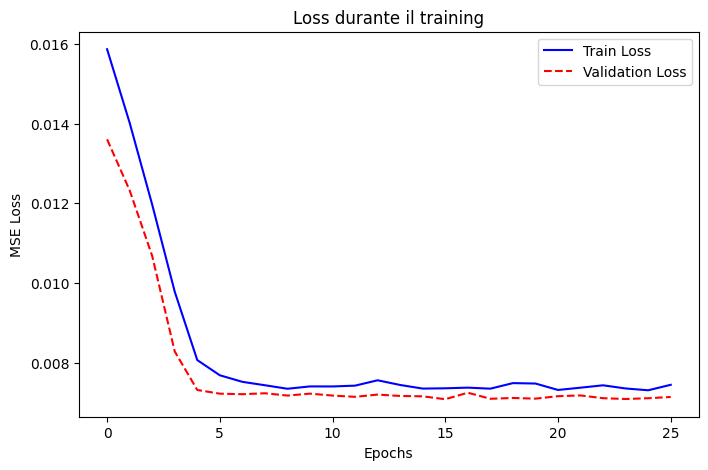

Grafico Loss salvato in ./tests/lstm_p_200_10/loss_plot.png


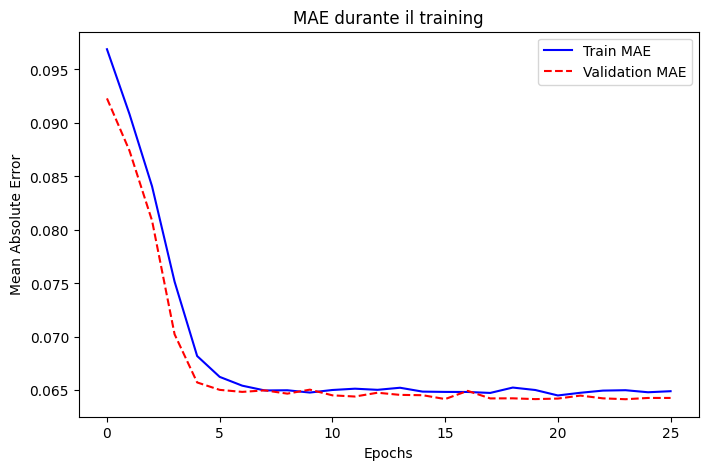

Grafico MAE salvato in ./tests/lstm_p_200_10/mae_plot.png


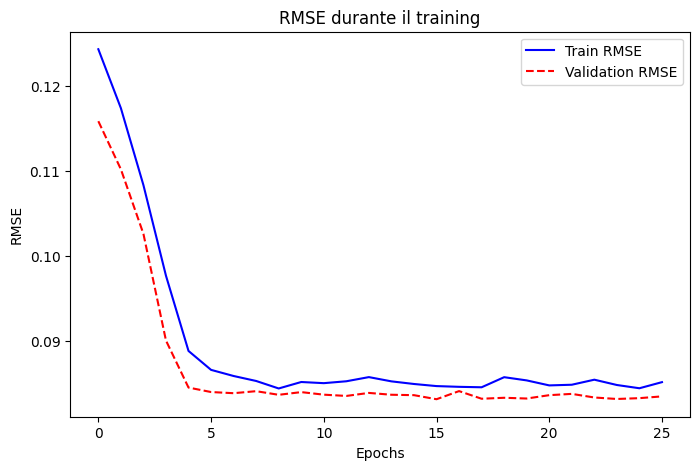

Grafico RMSE salvato in ./tests/lstm_p_200_10/rmse_plot.png


In [ ]:
lstm_model.plot_training_history()

In [ ]:
lstm_model.evaluate(X_test, y_test)

Metriche salvate in ./tests/lstm_p_200_10/evaluation_metrics.csv


{'MSE': 0.006315483641549112,
 'RMSE': 0.07947001724895442,
 'MAE': 0.0624997352008226,
 'R2': 0.5396169527421166}

In [ ]:
y_pred = lstm_model.predict(X_test)  
comparison_df = lstm_model.compare_predictions(y_test, y_pred)  

Confronto predizioni salvato in ./tests/lstm_p_200_10/predictions_comparison.csv


In [ ]:
lstm_model.plot_predictions(y_test, y_pred, 50)

Grafico salvato in ./tests/lstm_p_200_10/predictions_plot_1.png
Grafico salvato in ./tests/lstm_p_200_10/predictions_plot_2.png
Grafico salvato in ./tests/lstm_p_200_10/predictions_plot_tot.png


In [ ]:
lstm_model.save_model()

Modello salvato in ./tests/lstm_p_200_10/lstm_model.h5


In [ ]:
lstm_model.save_summary()

Sommario del modello salvato in ./tests/lstm_p_200_10/model_summary.txt


In [ ]:
lstm_model.save_training_history()

Training history salvata in ./tests/lstm_p_200_10/training_history.npy
